# lisabeta: tutorial for basics of the interface and MBHB sky localization

This notebook describes basics about lisabeta, a package for gravitational wave data analysis for the instrument LISA.

lisabeta is now publicly available here:

[https://gitlab.in2p3.fr/marsat/lisabeta](https://gitlab.in2p3.fr/marsat/lisabeta)
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/SylvainMarsat/lisabeta_sky_tutorial/blob/main/lisabeta_mbhb_sky_tutorial.ipynb)

## Installation on Google Colab

In [ ]:
!apt-get install libgsl-dev
!gsl-config --prefix
!apt-get install fftw3-dev

In [ ]:
!apt-get install cm-super dvipng texlive-latex-extra texlive-latex-recommended #needed to support tex in matplotlib (takes just over 1 min)

In [ ]:
!git clone --recursive --depth=1 https://gitlab.in2p3.fr/marsat/lisabeta.git lisabeta_code
!if grep -q default lisabeta/lisabeta-py310.yml; then sed -i.bak -e '4d;' lisabeta_code/lisabeta-py310.yml; fi;
!sed -i.bak 's\/path/to/gsl\/usr:/usr/local\g;s\:/path/to/LDC/ldc/common/constants\\' lisabeta_code/setup.cfg

In [ ]:
%pip install ./lisabeta_code

## Imports

In [1]:
import os
import h5py
import itertools
import copy
import numpy as np
import scipy
import json
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm

from astropy.cosmology import Planck15 as cosmo

In [2]:
import lisabeta
import lisabeta.pyconstants as pyconstants
import lisabeta.tools.pytools as pytools
import lisabeta.tools.pyspline as pyspline
import lisabeta.tools.pyoverlap as pyoverlap
import lisabeta.lisa.pyresponse as pyresponse
import lisabeta.lisa.snrtools as snrtools
import lisabeta.lisa.pyLISAnoise as pyLISAnoise
import lisabeta.lisa.lisa as lisa
import lisabeta.lisa.lisatools as lisatools
import lisabeta.lisa.lisa_fisher as lisa_fisher
import lisabeta.utils.plotutils as plotutils

/Users/marsat/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/waveforms/bbh/lalsim_wrap.py:10: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
np.set_printoptions(legacy='1.25')
%matplotlib inline

# A quick look at the lisabeta interface

## Setting parameters

In [4]:
# Redshift z=6
cosmo.luminosity_distance(6.).value

59046.10457286159

In [5]:
# Physical signal parameters

params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(6).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [6]:
# Tool to complete the dictionary with other mass/spin combinations
pytools.complete_all_params(params)

{'M': 5000000.0,
 'q': 4.0,
 'chi1': 0.7,
 'chi2': 0.4,
 'Deltat': 0.0,
 'dist': 59046.10457286159,
 'inc': 1.0471975511965976,
 'phi': 1.2,
 'lambda': 0.5,
 'beta': 0.9,
 'psi': 2.7,
 'Lframe': True,
 'm1': 4000000.0,
 'm2': 1000000.0,
 'Mchirp': 1665106.4148037464,
 'eta': 0.16,
 'chis': 0.55,
 'chia': 0.14999999999999997,
 'chip': 0.6399999999999999,
 'chim': 0.4799999999999999,
 'chiPN': 0.5808141592920354}

In [7]:
# Parameters for the waveform generation and other options

waveform_params = {
    
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    
    # Waveform approximant and set of harmonics to use (None to use all available)
    "approximant": "IMRPhenomXHM",
    "modes": [(2,2), (2,1), (3,3), (3,2), (4,4)],
    
    # LISA response options
    "TDI": "TDIAET",
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

## Waveform and response generation function

In [8]:
# Generate waveform and LISA transfer functions separately
wftdi = lisa.GenerateLISATDI_SMBH(params, **waveform_params)

In [9]:
%timeit lisa.GenerateLISATDI_SMBH(params, **waveform_params)

1 ms ± 22.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
wftdi.keys()

dict_keys(['params', 'modes', 'fpeak', 'Mfinal', 'chifinal', (2, 2), (2, 1), (3, 3), (3, 2), (4, 4)])

In [16]:
# List of modes
wftdi['modes']

[(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)]

In [17]:
# Each mode has its own amplitude, phase, Doppler phase, transfer functions
wftdi[(2,2)].keys()

dict_keys(['freq', 'amp', 'phase', 'tf', 'phaseRdelay', 'transferL1', 'transferL2', 'transferL3'])

In [18]:
# The data is represented on a sparse set of frequencies
wftdi[(2,2)]['freq'].shape[0]

308

/Users/marsat/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/utils/plotutils.py:120: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  f = plt.figure(0, figsize=size)


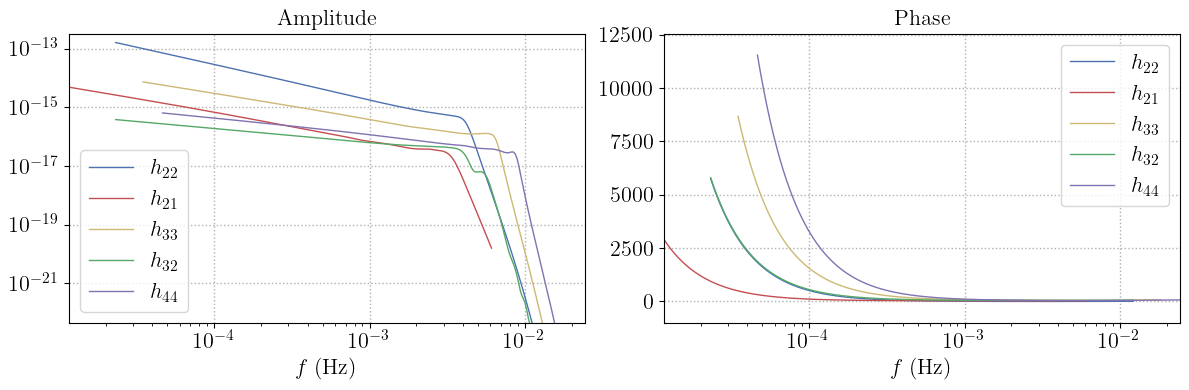

<Figure size 800x400 with 0 Axes>

In [22]:
# Amplitude and phase of the hlm in the waveform

labels = [r'$h_{22}$', r'$h_{21}$', r'$h_{33}$', r'$h_{32}$', r'$h_{44}$']
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], *[[wftdi[lm]['freq'], np.abs(wftdi[lm]['amp'])] for lm in wftdi['modes']], labels=labels)
plotutils.lloglinearplot(axs[1], *[[wftdi[lm]['freq'], wftdi[lm]['phase']] for lm in wftdi['modes']], labels=labels)
for i in range(2):
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
axs[0].legend(loc='lower left')
axs[1].legend(loc='upper right')
axs[0].set_title(r'Amplitude')
axs[1].set_title(r'Phase')
fig.tight_layout()

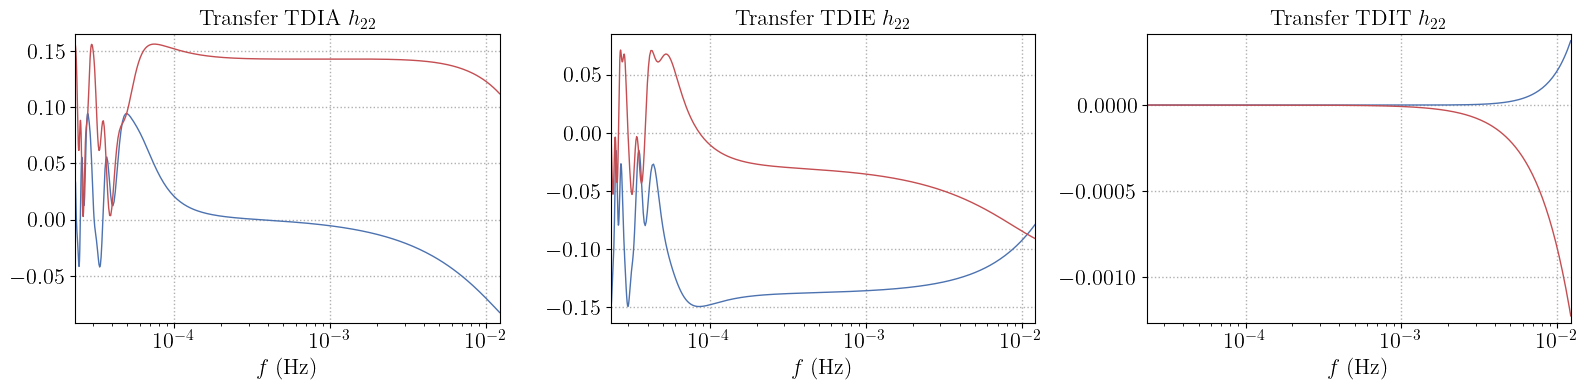

<Figure size 800x400 with 0 Axes>

In [23]:
# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    plotutils.lloglinearplot(axs[i], [wftdi[lm]['freq'], np.real(wftdi[lm][transferstr]) * rescaling], [wftdi[lm]['freq'], np.imag(wftdi[lm][transferstr]) * rescaling])
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
fig.tight_layout()

/Users/marsat/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/utils/plotutils.py:120: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  f = plt.figure(0, figsize=size)


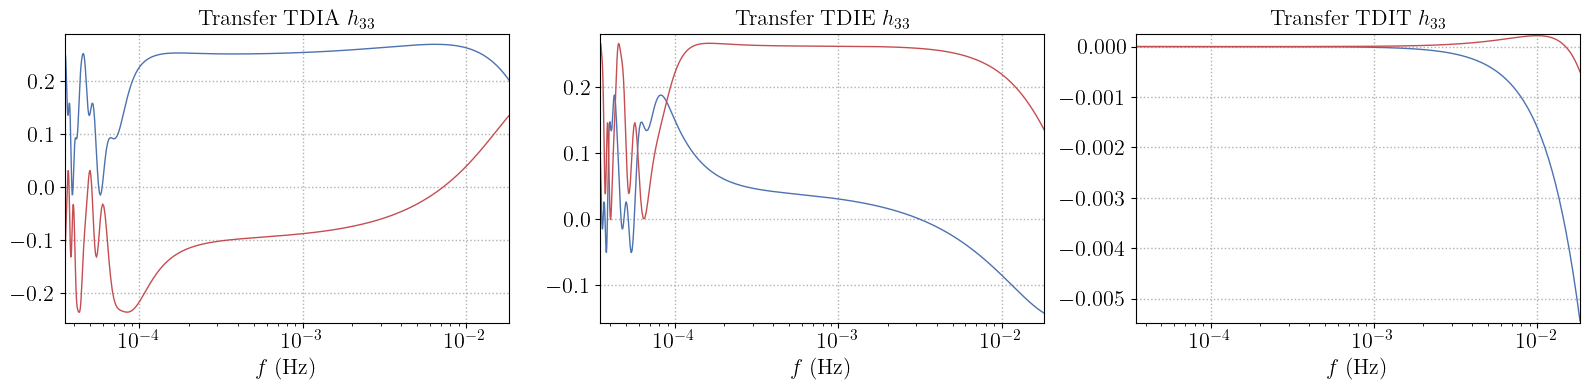

<Figure size 800x400 with 0 Axes>

In [24]:
# Transfer functions, mode h33 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{33}$', 'Transfer TDIE $h_{33}$', 'Transfer TDIT $h_{33}$']
lm = (3,3)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    plotutils.lloglinearplot(axs[i], [wftdi[lm]['freq'], np.real(wftdi[lm][transferstr]) * rescaling], [wftdi[lm]['freq'], np.imag(wftdi[lm][transferstr]) * rescaling])
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
fig.tight_layout()

## Compute SNR

In [33]:
# Compute the SNR (h|h) summed over 3 TDI channels
snrtools.lisa_mbhb_snr(params, **waveform_params)

980.5674891476933

In [34]:
%timeit snrtools.lisa_mbhb_snr(params, **waveform_params)

3.9 ms ± 154 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
# More detailed interface: also stores SNR mode-by-mode (and some reconditioning of the waveform)
tdisignal = lisa.GenerateLISATDISignal_SMBH(params, **waveform_params)

In [36]:
# Total SNR (all channels, all modes)
tdisignal['SNR']

980.5674891476933

In [39]:
tdisignal.keys()

dict_keys(['SNR', 'SNR2modematrix', 'wftdi', 'tdi', 'weightedtdi'])

In [40]:
# Matrix of (lm,l'm') mode contributions to the SNR^2
tdisignal['SNR2modematrix']

{'modes': [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)],
 'matrix': array([[ 7.43178659e+05, -1.37740532e+04,  6.81625943e+03,
         -3.07874367e+04, -4.19437902e+02],
        [-1.37740480e+04,  1.67179091e+03,  3.86674146e+02,
          8.40647342e+02,  2.53494608e+01],
        [ 6.81579719e+03,  3.86630864e+02,  2.43301867e+05,
         -1.78573974e+01,  3.70860832e+02],
        [-3.07874367e+04,  8.40631505e+02, -3.79139868e+01,
          2.39911299e+03, -6.02706394e+01],
        [-4.19425601e+02,  2.53458344e+01,  3.70172684e+02,
         -6.13179585e+01,  4.42219996e+04]])}

In [41]:
# SNR in individual modes
list(zip(tdisignal['SNR2modematrix']['modes'], np.sqrt(np.diag(tdisignal['SNR2modematrix']['matrix']))))

[((2, 2), 862.0781048195975),
 ((2, 1), 40.887539832854),
 ((3, 3), 493.25639099689135),
 ((3, 2), 48.98074104455781),
 ((4, 4), 210.2902745699225)]

/tmp/ipykernel_61013/1151499152.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])
/tmp/ipykernel_61013/1151499152.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])


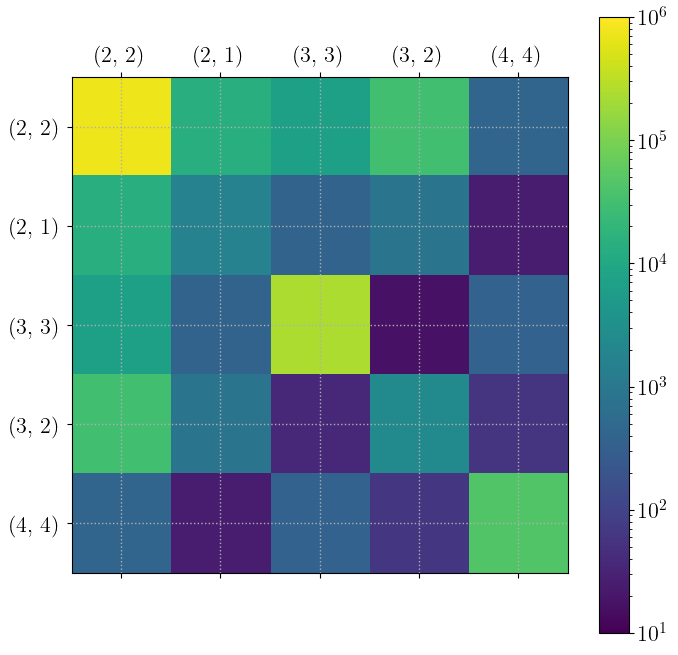

In [50]:
fig, ax = plt.subplots(1,1, figsize=[8,8])
cax = ax.matshow(np.abs(tdisignal['SNR2modematrix']['matrix']), interpolation='nearest', norm=mpl.colors.LogNorm(vmin=10., vmax=1e6))
ax.set_xticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])
ax.set_yticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])

fig.colorbar(cax)

## Fisher matrix

In [11]:
list_params = ['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']
params_complete = pytools.complete_mass_params(params)
params_complete = pytools.complete_spin_params(params_complete)

# Use frequency grid adjusted to inspiral phasing at low frequencies, logarithmic at high frequencies, with default number of points
freqs = ['nyquist_log', None]

# Do the computation in the L-frame
Lframe = True

steps = lisa_fisher.get_default_steps_smbh(params['M'])

steps

{'M': 4.000000000000002e-06,
 'Mchirp': 4.000000000000002e-06,
 'm1': 4.000000000000002e-06,
 'm2': 4.000000000000002e-06,
 'q': 0.00010000000000000009,
 'eta': 9.999999999999997e-06,
 'chi1': 9.999999999999997e-06,
 'chi2': 9.999999999999997e-06,
 'chip': 9.999999999999997e-06,
 'chim': 9.999999999999997e-06,
 'chis': 9.999999999999997e-06,
 'chia': 9.999999999999997e-06,
 'chiPN': 9.999999999999997e-06,
 'Deltat': 0.00010000000000000009,
 'dist': 9.999999999999997e-06,
 'inc': 0.00010000000000000009,
 'phi': 0.00010000000000000009,
 'lambda': 0.00010000000000000009,
 'beta': 0.00010000000000000009,
 'psi': 0.00010000000000000009}

In [15]:
%%time
fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=freqs, steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

CPU times: user 1.37 s, sys: 157 ms, total: 1.53 s
Wall time: 1.28 s


In [76]:
fishercov.keys()

dict_keys(['params', 'list_params', 'fisher', 'cov', 'Lframe'])

In [78]:
# Fisher covariance matrix, 11*11
fishercov['list_params'], fishercov['cov']

(['M',
  'q',
  'chi1',
  'chi2',
  'Deltat',
  'dist',
  'inc',
  'phi',
  'lambda',
  'beta',
  'psi'],
 array([[ 2.17389503e+06,  4.54597444e+00,  6.26470042e-01,
         -4.43609677e-01, -2.38101274e+02, -1.92541990e+04,
         -1.07867069e+00,  6.38155250e+00,  7.67032878e-01,
         -9.17664534e-01,  4.32203949e+00],
        [ 4.54597444e+00,  1.29309769e-05,  5.96695043e-07,
         -1.68914762e-06, -1.03138480e-03, -5.53534384e-02,
         -3.94125334e-06,  2.13572227e-05,  1.62795867e-06,
         -2.66089559e-06,  1.02375066e-05],
        [ 6.26470042e-01,  5.96695043e-07,  6.03192055e-07,
         -2.54769585e-07,  1.81638232e-04,  3.50984409e-02,
          1.60961366e-07, -4.58260495e-06, -6.28053906e-07,
          4.63479593e-07, -3.08801964e-06],
        [-4.43609677e-01, -1.68914762e-06, -2.54769585e-07,
          1.60225876e-06,  1.34171861e-04, -1.54231278e-01,
          1.68908120e-06,  9.12528100e-06,  3.43331007e-06,
         -1.39311559e-06,  1.52015392e-05]

In [79]:
('M', np.sqrt(fishercov['cov'][0,0])/params_complete['M'])

('M', 0.0003686033629914572)

In [86]:
('q', np.sqrt(fishercov['cov'][1,1]))

('q', 0.003595966756597771)

In [80]:
('dist', np.sqrt(fishercov['cov'][5,5])/params_complete['dist'])

('dist', 0.004310470364249975)

## Likelihood

In [51]:
template_params = params.copy()
template_params['q'] *= (1 + 1e-3)

In [52]:
# Historic 0-noise likelihood
likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params)

In [53]:
# Faster likelihood, based on residuals from a reference signal -- can also accomodate real data
likelihood_residuals = lisa.LikelihoodLISASMBH_LinearResiduals(params, ngrid=128, **waveform_params)

In [54]:
likelihood.lnL(template_params)

-3.842434602614958

In [55]:
likelihood_residuals.lnL(template_params)

-3.8331906090905563

In [56]:
%timeit likelihood.lnL(template_params)

5.95 ms ± 267 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
%timeit likelihood_residuals.lnL(template_params)

1.22 ms ± 34.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Interface for Bayesian parameter estimation

Sampler `ptemcee` available at `https://github.com/SylvainMarsat/ptemcee`

## Interface and run parameters

Example `.json` submission file:
<code>{
  "source_params": {
    "M": 4e6,
    "q": 3.0,
    "chi1": 0.5,
    "chi2": 0.2,
    "Deltat": 0.0,
    "dist": 3.65943e+04,
    "inc": 1.0471975511965976,
    "phi": 1.2,
    "lambda": 0.8,
    "beta": 1.0471975511965976,
    "psi": 1.7,
    "Lframe": true
  },
  "waveform_params": {
    "minf": 1e-5,
    "maxf": 0.5,
    "t0": 0.0,
    "timetomerger_max": 1.0,
    "fend": null,
    "tmin": null,
    "tmax": null,
    "phiref": 0.0,
    "fref_for_phiref": 0.0,
    "tref": 0.0,
    "fref_for_tref": 0.0,
    "force_phiref_fref": true,
    "toffset": 0.0,
    "modes": null,
    "TDI": "TDIAET",
    "acc": 1e-4,
    "order_fresnel": 0,
    "approximant": "IMRPhenomHM",
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": false,
    "TDIrescaled": true,
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": false,
        "WDduration" : 0.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  },
  "prior_params": {
    "list_params": ["M", "q", "chi1", "chi2", "Deltat", "dist", "inc", "phi", "lambda", "beta", "psi"],
    "infer_params": ["M", "q", "chi1", "chi2", "Deltat", "dist", "inc", "phi", "lambda", "beta", "psi"],
    "params_range": [[1e6, 1e7], [1., 10.], [-1.0, 1.0], [-1.0, 1.0], [-600.0, 600.0], [10e3, 100e3], [], [], [], [], []],
    "prior_type": ["uniform", "uniform", "uniform", "uniform", "uniform", "uniform", "sin", "uniform", "uniform", "cos", "uniform"],
    "wrap_params": null
  },
  "run_params": {
    "out_dir": "/Users/marsat/Projects/lisabeta/lisabeta/examples/ptemcee_smbh/",
    "out_name": "smbh_example",
    "sampler": "ptemcee",
    "sample_Lframe": true,
    "multimodal": true,
    "multimodal_pattern": "8modes",
    "p_jump": 0.5,
    "likelihood_method": "residuals",
    "likelihood_residuals_ngrid": 128,
    "skip_fisher": false,
    "init_method": "fisher",
    "init_scale_cov": 1.0,
    "zerolike": false,
    "n_temps": 10,
    "temp_max": null,
    "n_walkers": 64,
    "n_iter": 4000,
    "burn_in": 1000,
    "autocor_method": "autocor_new",
    "thin_samples": true,
    "upsample": 1,
    "seed": null,
    "print_info": true,
    "n_iter_info": 50,
    "output": true,
    "output_raw": true
  }
}
</code>

Run with `python <lisabeta>/lisabeta/inference/ptemcee_smbh.py example.json`

## Load results

In [100]:
subsdir = '/Users/marsat/Projects/lisabeta/examples/'
#datadir = '/Users/marsat/Projects/lisabeta/examples/'
datadir = '/Users/marsat/Projects/lisabeta/examples/long/'

In [101]:
subfile = subsdir + 'smbh_example_cc.json'
postfile = datadir + 'smbh_example.h5'

params_post = plotutils.load_params_posterior_lisa_smbh(subfile, postfile)

post_raw_file = datadir + 'smbh_example_raw.h5'

post_raw = {}
with h5py.File(post_raw_file, 'r') as hf:
    for p in params_post['prior_params']['infer_params']:
        post_raw[p] = hf[p][:]
    post_raw['lnL'] = hf['lnlike'][:]

In [52]:
params_post.keys()

dict_keys(['fishercov', 'injparams_SSBframe', 'injparams_Lframe', 'waveform_params', 'prior_params', 'run_params', 'post'])

In [53]:
params_post['post'].keys()

dict_keys(['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi', 'lnL', 'lnpost', 'Lframe', 'm1', 'm2', 'Mchirp', 'eta', 'chis', 'chia', 'chip', 'chim', 'chiPN'])

## Likelihood values

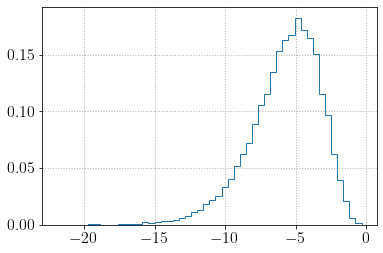

In [82]:
# We cheated with Fisher initialization, chains are good from the beginning !
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(params_post['post']['lnL'], histtype='step', density=True);

In [58]:
def plot_postraw_lnL_trace(post_raw, rangey=None, title=''):

    nwalkers = post_raw['lnL'].shape[0]
    nsteps = post_raw['lnL'].shape[1]

    #Threshold to eliminate the -1e99 values that mess up plots
    masks = [post_raw['lnL'][i] > -1e12 for i in range(nwalkers)]
    fig, ax = plt.subplots(1,1, figsize=[16,4])
    plotutils.llogplot(ax, *[[np.arange(nsteps)[masks[i]], -post_raw['lnL'][i][masks[i]]] for i in range(nwalkers)], rangey=rangey)

    ax.set_xlabel(r'$\mathrm{Steps}$')
    ax.set_ylabel(r'$-\ln \mathcal{L}$')
    ax.set_title(title)

    return fig

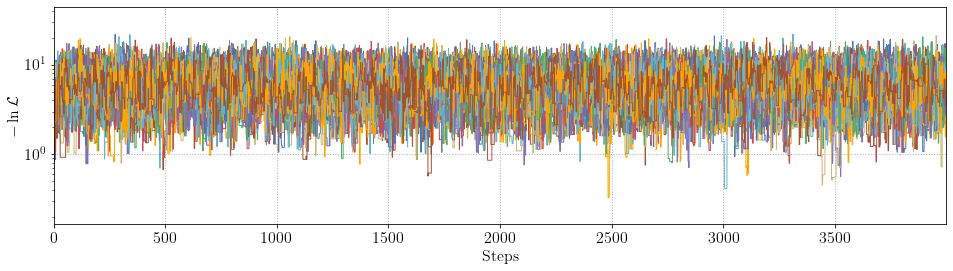

<Figure size 576x288 with 0 Axes>

In [83]:
# We cheated with Fisher initialization, chains are good from the beginning !
plot_postraw_lnL_trace(post_raw);

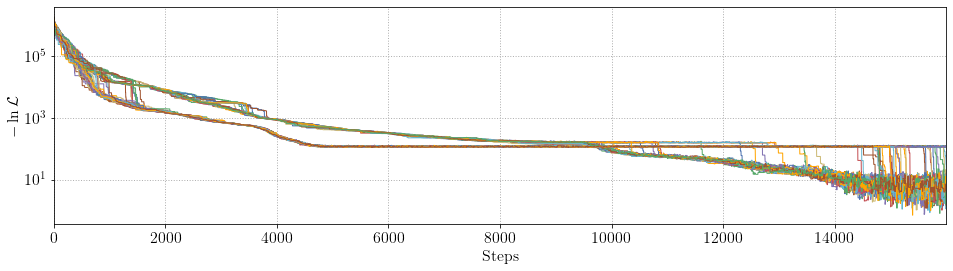

<Figure size 576x288 with 0 Axes>

In [103]:
# WARNING: at present burn-in hard for loud signals, can get stuck in secondary maxima (PT helps)

plot_postraw_lnL_trace(post_raw);

## Posterior

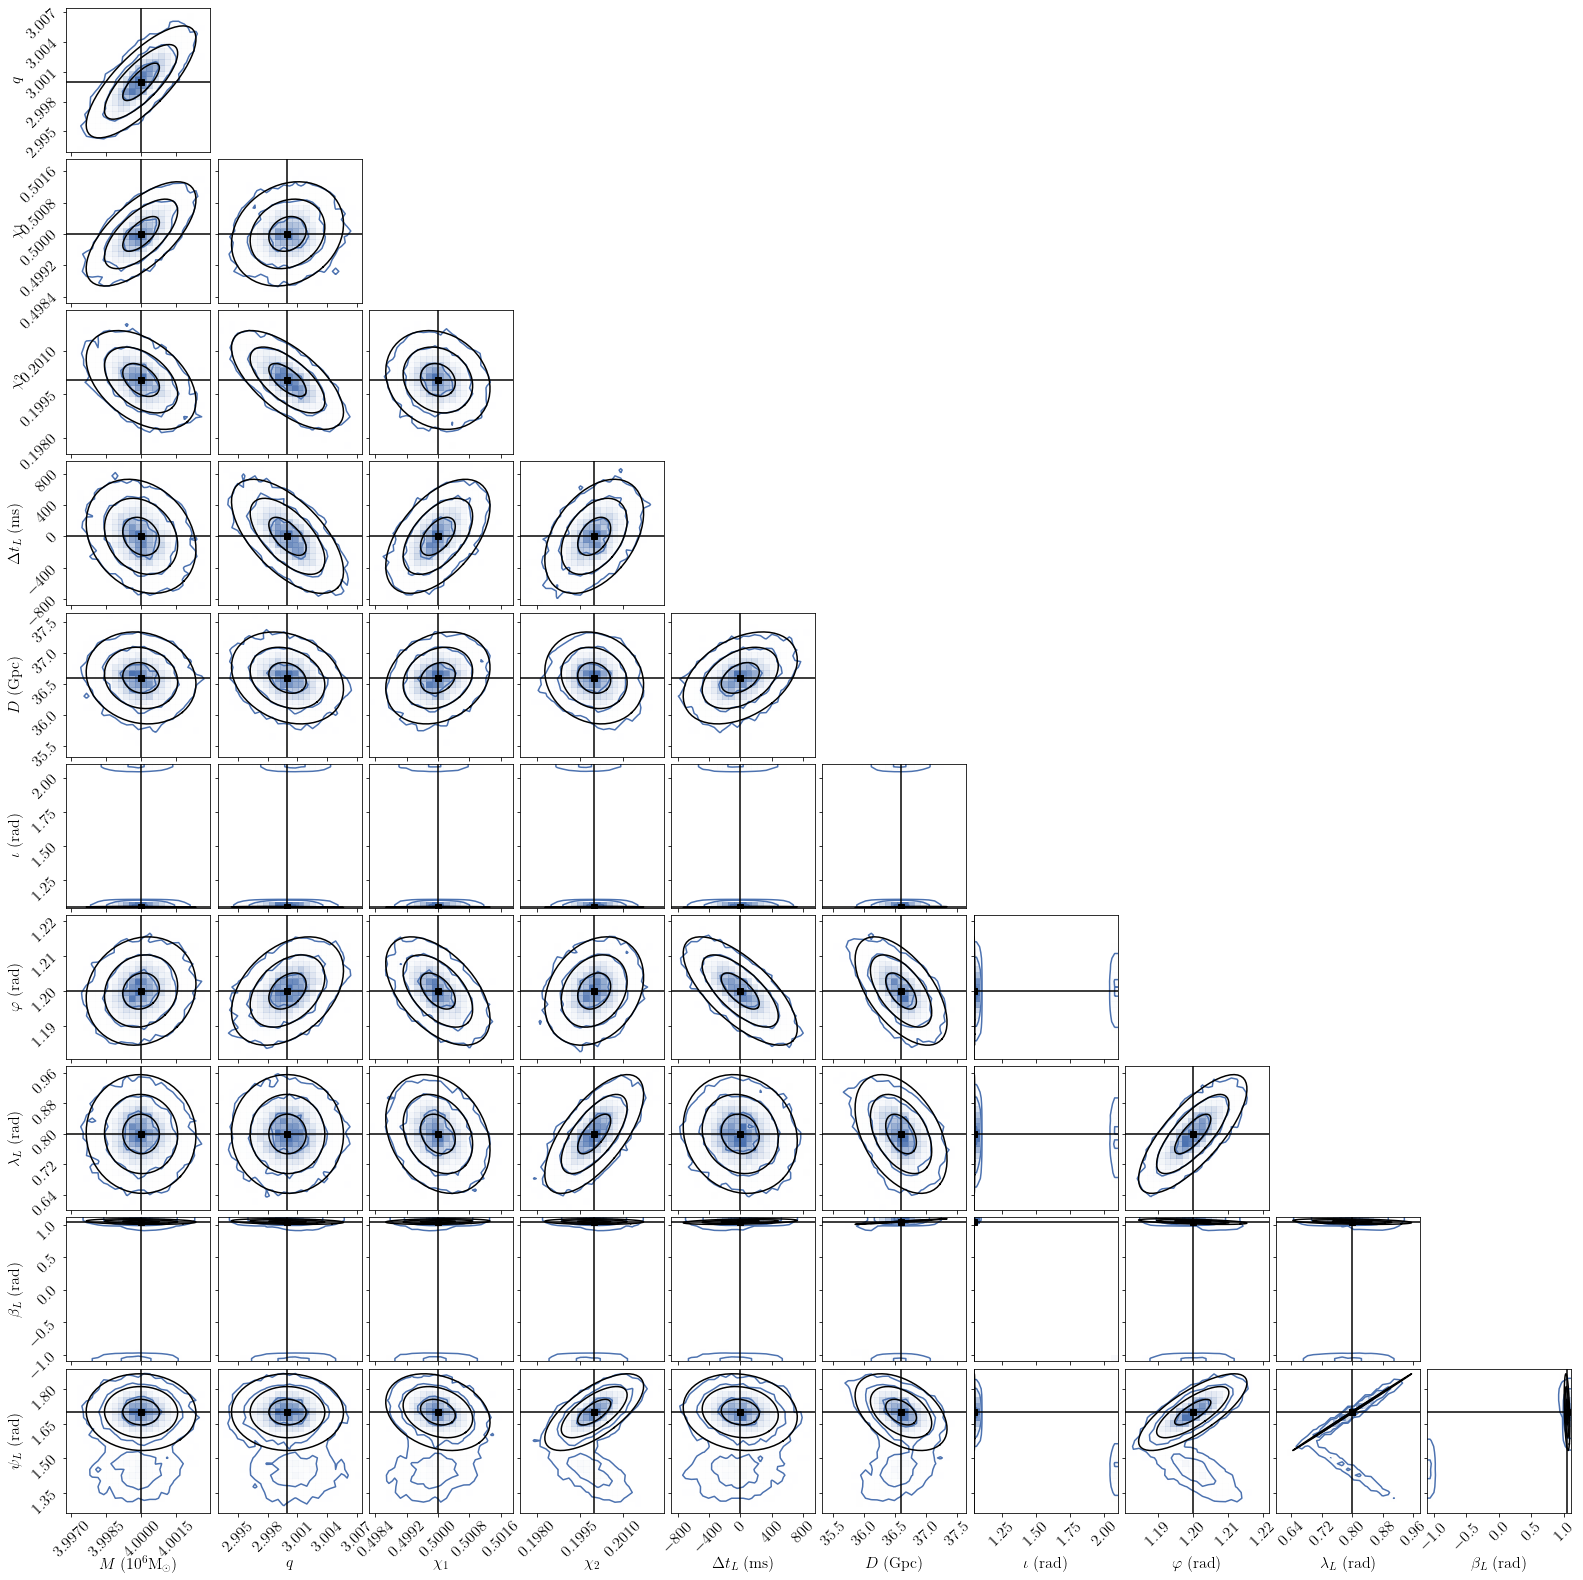

In [85]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], params_post['post'], output=False, histograms=True, fisher=True, fishercov=params_post['fishercov'], params=['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi'], Lframe=True, color=plotutils.plotpalette[0], cov_color='k', show_truths=True, truth_color='k', bins=25, show_histograms=False, plot_datapoints=False);

# Noise and choice of TDI variables

## Instrumental noise and confusion background interface

In [ ]:
# Evaluate noise with different WD backgrounds (different LISA durations)
pyLISAnoise.evaluate_AET_psd()

## Different TDI generations

# Numerics: frequency arrays, overlaps

# Other interfaces: external data, time-domain